### Model that will predict strength of bond based on bonding parameters
Currently data is read from a csv file with the columns: 
**sampleID,temperature,bondDuration,voltagePower,bondForce,**
**bondMiddle,bondedArea,bondItself,labels,heelDeformation,**
**centerDeformation,failureMode**

* sampleID - substrate number
* temperature - temperature at which bonds are made, in Celsius 
* bond duration - measured in milliseconds, duration of bonding
* voltage power - measured in volts, power used on bonds
* bond force - measured in gram force, force used on bonds
* bond middle - length (long) of deformation area of the ribbon
* bond area - length (long) of heat infected area of the ribbon
* bond itself - length of ribbon that isn't deformed
* bond length difference - difference in length between the deformation area and undeformed ribbon
* labels - strength measurements, in grams, of the bonds
* heel deformation - percent change measurements of the deformation area of ribbon compared to undeformed ribbon
* center deformation - percent change measurements of the heat infected area of the ribbon compared to undeformed ribbon
* failure mode - noted failure mode of the ribbon during mechanical testing
* annealed - 0 or 1, noting if bond was not annealed or annealed
* annealing temperature - note of what the annealing temperature for the bond was, in Kelvin
* annealing duration - note of how long the bond was annealed for, in seconds

Two models are run, where labels and failure mode are the labels, and the rest of the data (minus the sampleID) are the features.  Feature important plots and data mapping plots are included as well.

In [1]:
import time
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np
import xgboost as xgb

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [49]:
dfTrain = pd.read_csv('GBM Analysis - anneal.csv')
labels = dfTrain['labels'].values

In [50]:
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 16 columns):
sampleID                43 non-null int64
temperature             43 non-null int64
bondDuration            43 non-null int64
voltagePower            43 non-null float64
bondForce               43 non-null int64
bondMiddle              43 non-null float64
bondedArea              43 non-null float64
bondItself              43 non-null float64
bondLengthDifference    43 non-null float64
labels                  43 non-null float64
heelDeformation         43 non-null float64
centerDeformation       43 non-null float64
failureMode             43 non-null object
annealed                43 non-null int64
annealedTemp            43 non-null int64
AnnealedDuration        43 non-null int64
dtypes: float64(8), int64(7), object(1)
memory usage: 5.5+ KB


In [51]:
le = LabelEncoder()
dfTrain['failureMode'] = le.fit_transform(dfTrain['failureMode'])
labelsFailureMode = dfTrain['failureMode'].values

Split the training and validating data for the model

In [52]:
trainData, validateData = train_test_split(dfTrain, test_size=0.05,
                                           random_state=42)

In [53]:
trainLabels = trainData['labels'].values
validateLabels = validateData['labels'].values

trainLabelsFailureMode = trainData['failureMode'].values
validateLabelsFailureMode = validateData['failureMode'].values

# dfTrain['labels'] = dfTrain['labels'].astype(float)

drop_var = ['sampleID', 'labels', 'failureMode']

# Drop id column, and labels that are added later
trainData = trainData.drop(drop_var, axis=1)
validateData = validateData.drop(drop_var, axis=1)

# These data matrices (trainDMatrix and validateDMatrix) are for the strength predictions 
trainDMatrix = xgb.DMatrix(trainData.as_matrix(),
                           label=trainLabels.astype(int))

validateDMatrix = xgb.DMatrix(validateData.as_matrix(),
                              label=validateLabels.astype(int))

# These data matrices (trainDMatrixFailure and validateDMatrixFailure) are for the failure mode predictions 
trainDMatrixFailure = xgb.DMatrix(trainData.as_matrix(),
                           label=trainLabelsFailureMode.astype(int))

validateDMatrixFailure = xgb.DMatrix(validateData.as_matrix(),
                           label=validateLabelsFailureMode.astype(int))

In [54]:
validateData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 37 to 25
Data columns (total 13 columns):
temperature             3 non-null int64
bondDuration            3 non-null int64
voltagePower            3 non-null float64
bondForce               3 non-null int64
bondMiddle              3 non-null float64
bondedArea              3 non-null float64
bondItself              3 non-null float64
bondLengthDifference    3 non-null float64
heelDeformation         3 non-null float64
centerDeformation       3 non-null float64
annealed                3 non-null int64
annealedTemp            3 non-null int64
AnnealedDuration        3 non-null int64
dtypes: float64(7), int64(6)
memory usage: 336.0 bytes


# Strength Prediction testing
Currently this model for predicting bond strength based on bonding and deformation parameters runs at 95% accuracy.

In [55]:
params = {
    'learning_rate'    : 0.038,
    'colsample_bytree' : 0.6,
    'subsample'        : 0.65,
    'max_depth'        : 7,
    'num_class'        : len(np.unique(trainLabels)),
    'seed'             : 0,
    'objective'        : 'multi:softprob',
    'eval_metric'      : 'merror',
    'booster'          : 'gbtree'
}

In [56]:
watchlist = [(trainDMatrix, 'train'), (trainDMatrix, 'eval')]

In [57]:
start_time = time.time()
clf = xgb.train(params, trainDMatrix, 210, evals=watchlist,
                early_stopping_rounds=60, verbose_eval=True)
print('Time taken to classify')
print((time.time() - start_time)/60)

[0]	train-merror:0.75	eval-merror:0.75
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 60 rounds.
[1]	train-merror:0.6	eval-merror:0.6
[2]	train-merror:0.575	eval-merror:0.575
[3]	train-merror:0.525	eval-merror:0.525
[4]	train-merror:0.55	eval-merror:0.55
[5]	train-merror:0.475	eval-merror:0.475
[6]	train-merror:0.55	eval-merror:0.55
[7]	train-merror:0.475	eval-merror:0.475
[8]	train-merror:0.475	eval-merror:0.475
[9]	train-merror:0.525	eval-merror:0.525
[10]	train-merror:0.475	eval-merror:0.475
[11]	train-merror:0.475	eval-merror:0.475
[12]	train-merror:0.5	eval-merror:0.5
[13]	train-merror:0.475	eval-merror:0.475
[14]	train-merror:0.45	eval-merror:0.45
[15]	train-merror:0.425	eval-merror:0.425
[16]	train-merror:0.45	eval-merror:0.45
[17]	train-merror:0.45	eval-merror:0.45
[18]	train-merror:0.45	eval-merror:0.45
[19]	train-merror:0.4	eval-merror:0.4
[20]	train-merror:0.4	eval-merror:0.4
[21]	train-

##### merror is the percent of incorrect cases, here we have a 95% accuracy at predicting strength of bonds

### Validation testing
Currently in progress to develop a new accuracy testing function

In [58]:
# validate_label_predictions = clf.predict(validateDMatrix)
# print(accuracy_score(validateLabels, validate_label_predictions.argmax(axis = 1)))

### Feature Importance Mapping

In [59]:
import operator
importances = clf.get_fscore()
print(importances)

{'f3': 132, 'f6': 433, 'f12': 1, 'f8': 400, 'f5': 463, 'f11': 2, 'f2': 193, 'f1': 43, 'f7': 313, 'f10': 14, 'f4': 484, 'f9': 219}


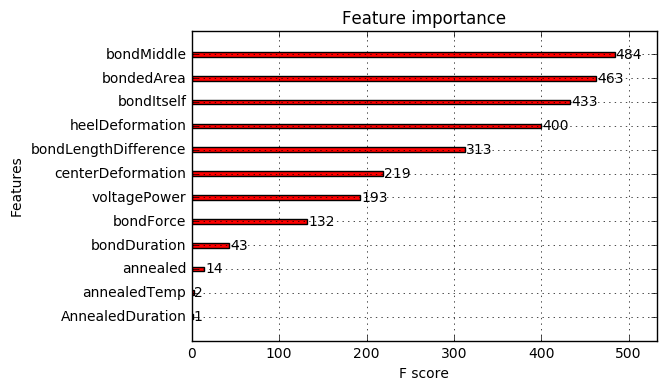

In [60]:
import matplotlib.pyplot as plt
# xgb.plot_importance(model)
# plt.show()
clf.get_fscore()
mapper = {'f{0}'.format(i): v for i, v in enumerate(trainData.columns)}
mapped = {mapper[k]: v for k, v in clf.get_fscore().items()}
mapped
xgb.plot_importance(mapped, color='red')
plt.show()

# Failure Mode Prediction Testing
Currently, this model does not work well (90% inaccuracy) due to too much of the data consisting of heel break failure modes.  The model needs to have more data that consists of different failure modes.

In [61]:
watchlist2 = [(trainDMatrixFailure, 'train'), (validateDMatrixFailure, 'eval')]

In [62]:
start_time2 = time.time()
clf2 = xgb.train(params, trainDMatrixFailure, 210, evals=watchlist,
                early_stopping_rounds=50, verbose_eval=True)
print('Time taken to classify')
print((time.time() - start_time2)/60)

[0]	train-merror:0.925	eval-merror:0.925
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 50 rounds.
[1]	train-merror:0.925	eval-merror:0.925
[2]	train-merror:0.925	eval-merror:0.925
[3]	train-merror:0.925	eval-merror:0.925
[4]	train-merror:0.925	eval-merror:0.925
[5]	train-merror:0.925	eval-merror:0.925
[6]	train-merror:0.925	eval-merror:0.925
[7]	train-merror:0.925	eval-merror:0.925
[8]	train-merror:0.925	eval-merror:0.925
[9]	train-merror:0.925	eval-merror:0.925
[10]	train-merror:0.925	eval-merror:0.925
[11]	train-merror:0.925	eval-merror:0.925
[12]	train-merror:0.925	eval-merror:0.925
[13]	train-merror:0.925	eval-merror:0.925
[14]	train-merror:0.925	eval-merror:0.925
[15]	train-merror:0.925	eval-merror:0.925
[16]	train-merror:0.925	eval-merror:0.925
[17]	train-merror:0.925	eval-merror:0.925
[18]	train-merror:0.925	eval-merror:0.925
[19]	train-merror:0.925	eval-merror:0.925
[20]	train-merror:0.925

In [63]:
import operator
importances = clf2.get_fscore()
print(importances)

{'f3': 27, 'f6': 117, 'f7': 71, 'f8': 110, 'f5': 118, 'f10': 19, 'f2': 36, 'f1': 13, 'f12': 5, 'f11': 10, 'f4': 94, 'f9': 61}


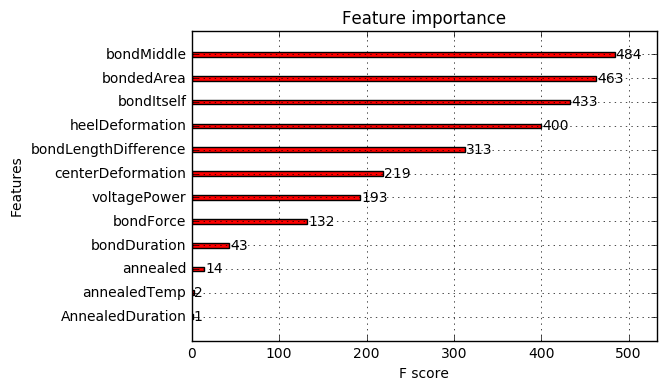

In [64]:
import matplotlib.pyplot as plt
# xgb.plot_importance(model)
# plt.show()
clf2.get_fscore()
mapper = {'f{0}'.format(i): v for i, v in enumerate(trainData.columns)}
mapped = {mapper[k]: v for k, v in clf.get_fscore().items()}
mapped
xgb.plot_importance(mapped, color='red')
plt.show()

In [65]:
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 16 columns):
sampleID                43 non-null int64
temperature             43 non-null int64
bondDuration            43 non-null int64
voltagePower            43 non-null float64
bondForce               43 non-null int64
bondMiddle              43 non-null float64
bondedArea              43 non-null float64
bondItself              43 non-null float64
bondLengthDifference    43 non-null float64
labels                  43 non-null float64
heelDeformation         43 non-null float64
centerDeformation       43 non-null float64
failureMode             43 non-null int64
annealed                43 non-null int64
annealedTemp            43 non-null int64
AnnealedDuration        43 non-null int64
dtypes: float64(8), int64(8)
memory usage: 5.5 KB


# Data Visualization of Failure Modes
Data visualization of the parameters of bonding (bond duration, voltage power, and bond force) mapped to the failure mode.

In [66]:
colormap = dfTrain[['failureMode']].copy()
colormap.loc[colormap['failureMode'] == 0, 'failureMode'] = 'r' # foot lift
colormap.loc[colormap['failureMode'] == 1, 'failureMode'] = 'k' # Heel Break
colormap.loc[colormap['failureMode'] == 2, 'failureMode'] = 'b' # Ribbon Break
print(colormap.failureMode.values)

['k' 'k' 'k' 'k' 'k' 'k' 'k' 'k' 'b' 'b' 'b' 'k' 'b' 'k' 'b' 'k' 'k' 'k'
 'k' 'b' 'k' 'k' 'k' 'k' 'k' 'k' 'k' 'b' 'k' 'k' 'b' 'k' 'k' 'k' 'r' 'r'
 'k' 'k' 'k' 'r' 'r' 'k' 'r']


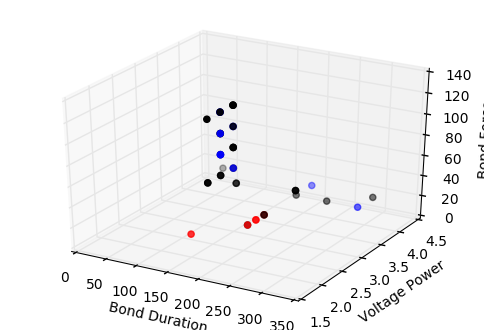

red is foot lift, blue is heel break, green is heel break


In [67]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
bondDuration = dfTrain['bondDuration'].values
voltagePower = dfTrain['voltagePower'].values
bondForce = dfTrain['bondForce'].values
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(bondDuration, voltagePower, bondForce, color=colormap.failureMode.values.tolist())
ax.set_xlabel('Bond Duration')
ax.set_ylabel('Voltage Power')
ax.set_zlabel('Bond Force')
plt.show()
print('red is foot lift, blue is heel break, green is heel break')

# Data Visualization of Strength
Data visualization of the parameters of bonding (bond duration, voltage power, and bond force) mapped to the strengths of bonds. 

In [68]:
colormapStrengths = pd.DataFrame(labels, columns = ['strengths'])
colormapStrengths['colors'] = np.zeros(len(colormapStrengths.strengths))

In [69]:
colormapStrengths.loc[colormapStrengths['strengths'] < 6, 'colors'] = 'r'
colormapStrengths.loc[colormapStrengths['strengths'] < 3, 'colors'] = 'k'
colormapStrengths.loc[colormapStrengths['strengths'] > 6, 'colors'] = 'b'

In [70]:
# # # Old Colormap Scheme using six colors, given up on because it was too confusing
# # new column of dataframe is written over based on the color correlating to the minimum strength
# colormapStrengths.loc[colormapStrengths['strengths'] < 10, 'colors'] = 'r'
# colormapStrengths.loc[colormapStrengths['strengths'] < 5, 'colors'] = 'gold'
# colormapStrengths.loc[colormapStrengths['strengths'] < 4, 'colors'] = 'dodgerblue'
# colormapStrengths.loc[colormapStrengths['strengths'] < 3, 'colors'] = 'g'
# colormapStrengths.loc[colormapStrengths['strengths'] < 2, 'colors'] = 'm'
# colormapStrengths.loc[colormapStrengths['strengths'] < 1, 'colors'] = 'indigo'
# colormapStrengths.loc[colormapStrengths['strengths'] < 0, 'colors'] = 'k'

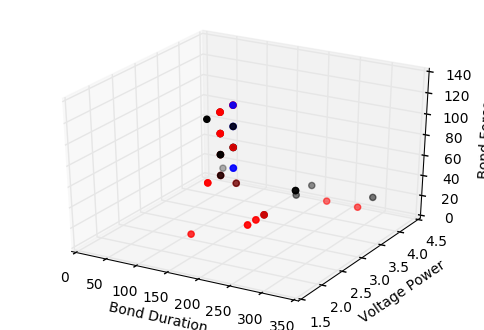

black is less than 3 grams
red is between 3 and 6 grams
blue is greater than 6 grams


In [71]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(bondDuration, voltagePower, bondForce, color=colormapStrengths.colors.values.tolist())
ax.set_xlabel('Bond Duration')
ax.set_ylabel('Voltage Power')
ax.set_zlabel('Bond Force')
plt.show()
print('black is less than 3 grams')
print('red is between 3 and 6 grams')
print('blue is greater than 6 grams')